# Tutorial

## Unraveling the Secrets of the Earth's Magnetic Field with *sedprep*

Welcome to the ``sedprep`` tutorial! In this notebook, we'll journey through the process of preprocessing palaeomagnetic sediment records, focusing on an example from Sweden. ``sedprep`` offers tools to estimate and correct for various distortions in sedimentary magnetic records. Our path will guide you from preparing your data over estimating necessary parameters to applying the parameters in a final preprocessing step.

### Setting the Stage
Before we dive into the parameter estimation, let's ensure we have all the right tools in our kit. The first step in any Python adventure involves importing the necessary packages. For this tutorial, apart from the Python package ``sedprep``, we'll need a couple of standard libraries: ``numpy`` and ``pandas`` for handling our data and ``matplotlib`` for bringing our results to life visually. Here's how to get started:

In [1]:
import numpy as np
import pandas as pd
import requests

from sedprep.data_handling import read_arch_data
from sedprep.utils import kalmag
from sedprep.optimizer import Optimizer

cpu


### The Significance of Archaeomagnetic Data and Lava Flow Samples
Before we delve into the sediment records, it's essential to understand the role of archaeomagnetic data. ``sedprep`` utilizes archaeomagnetic data and lava flow samples as globally distributed independent magnetic information. This invaluable information, coupled with prior knowledge of the geomagnetic field, forms the backbone of our Bayesian modeling technique. By comparing sediment records to a signal reference signal influenced by the prior knowledge and the independent measurements, ``sedprep`` meticulously estimates parameters that bring clarity to the otherwise distorted magnetic signals in sediment records. Here we use the dataset from [Schanner et al (2022)](https://doi.org/10.1029/2021JB023166). It is publically available using the links in the next cell.

In [2]:
import io
pre = "https://nextcloud.gfz-potsdam.de/s/"
rej_response = requests.get(f"{pre}WLxDTddq663zFLP/download")
rej_response.raise_for_status()
with np.load(io.BytesIO(rej_response.content), allow_pickle=True) as fh:
    to_reject = fh["to_reject"]
data_response = requests.get(f"{pre}r6YxrrABRJjideS/download")
arch_data = read_arch_data(io.BytesIO(data_response.content), to_reject)
arch_data.head(4)

Rejected 347 outliers.


c:\Users\Lukas\miniconda3\envs\prep\lib\site-packages\sedprep\data_handling.py:553: UserWarning: Records with indices [   72    73    74    75    76    77    78    79    80    81   108   109
   357   358  1065  1066  1153  2402  2575  2671  2753  2756  2757  3036
  3215  3217  3218  3219  3220  3221  3222  3223  3224  3225  3503  3772
  3988  4047  4235  4415  4504  4530  4531  4655  5172  5326  5434  5496
  5551  5707  5763  5802  5805  5959  6053  6105  6647  6706  6781  6809
  7149  7580  7585  7593  7692  7702  7735  7776  7806  7826  7881  7979
  8067  8296  8327  8427  8464  8510  8670  8708  8752  9224  9653 10002
 10132 10331 10509 10604 10647 11527 11758] contain declination, but not inclination! The errors need special treatment!
To be able to use the provided data, these records have been dropped from the output.


,t,dt,rad,colat,lat,lon,D,dD,I,dI,F,dF,type,UID,FID
0,-12000,619.0,6371.2,70.3294,19.6706,258.5713,-10.9,1.667730,48.5,1.105071,38.6,2.0,arch_data,13128,"b'\xf0\xbf\xe2\x01\xce\x1bJ,\x8ax\xc9=\x11\x82..."
1,-12000,100.0,6371.2,70.5300,19.4700,205.1000,NaN,6.238796,23.3,5.730000,37.2,4.9,arch_data,3413,"b'\xf0\xbf\xe2\x01\xce\x1bJ,\x8ax\xc9=\x11\x82..."
2,-12000,1000.0,6371.2,47.2010,42.7990,141.3220,20.3,6.552033,71.8,2.046429,37.6,1.9,arch_data,3467,"b'\xf0\xbf\xe2\x01\xce\x1bJ,\x8ax\xc9=\x11\x82..."
3,-11938,163.0,6371.2,61.6830,28.3170,343.3920,1.6,1.708651,46.0,1.186929,35.6,3.7,arch_data,10712,"b'\xf0\xbf\xe2\x01\xce\x1bJ,\x8ax\xc9=\x11\x82..."


### Preparing Sediment Data for ``sedprep`` Analysis
In this section, we focus on importing and formatting sediment data for compatibility with sedprep. We utilize a dataset from GEOMAGIA [Braun et al (2015)](https://doi.org/10.1186/s40623-015-0233-z), specifically with the Location Code "FUR" and CoreID "P2". The raw dataset is available in the ``FUR_P2_raw_geomagia.csv`` file. It's crucial that the data is structured according to ``sedprep``'s specifications for efficient analysis.

The sedprep package requires data to be structured with specific columns, as detailed below:

- __t__: Age in calendar years
- __dt__: Age uncertainties
- __depth__: Depth in centimeter
- __lat__: Latitude of core location
- __lon__: Longitude of core location
- __D__: Declination
- __I__: Inclination
- __F__: Relative palaeointensity
- __dD__: Measurement uncertainties for Declination
- __dI__: Measurement uncertainties for Inclination
- __dF__: Measurement uncertainties for Relative palaeointensity
- __subs__: Name of subsections
- __type__: Set to "sediment" for differentiation
- __UID__: Unique identifier
- __FID__: SHA-256 hash

These requirements ensure that the data is appropriately prepared for the ``sedprep`` processing pipeline. For data not sourced from GEOMAGIA, custom preparation scripts may be necessary. The data preparation steps for the GEOMAGIA dataset are encapsulated within the ``data_preparation.py`` file.

The Python snippet below outlines the process for preparing the GEOMAGIA "FUR" dataset for ``sedprep``. This includes reading the raw data, adjusting declinations, converting MAD values to measurement uncertainties using the method described in [Khokhlov and Hulot](https://doi.org/10.1093/gji/ggv451), evaluating the age-depth model at given depths, and outlier removal based on unique identifiers.

In [5]:
import arviz as az
from src.data_preparation import read_geomagia_data, remove_outliers, evaluate_adm
from sedprep.data_handling import adjust_declination, mad_to_alpha95, alpha95_to_dD_dI
from sedprep.constants import default_alpha95
import tempfile

remove_uids_DI = [0, 1] + [x for x in range(120, 128)]
remove_uids_F = [0, 1] + [x for x in range(120, 128)]

df = read_geomagia_data("FUR_P2")

# Adjust declination to be within -180 to 180 degrees
df["D"] = adjust_declination(df["D"])

# Convert MAD values to alpha95, then to measurement uncertainties
df["alpha_95"] = mad_to_alpha95(df["MAD"])
df["alpha_95"].where(df["alpha_95"].notna(), other=default_alpha95, inplace=True)
df["dD"], df["dI"] = alpha95_to_dD_dI(df["alpha_95"], df["I"], df["lat"])
df["type"] = "sediment"

# Evaluate age-depth model at depths
r = requests.get(f"{pre}jYd7ka4ncWeiF6e/download")
with tempfile.NamedTemporaryFile(mode='w+b', delete=False) as temp_file:
    temp_file.write(r.content)
idata = az.from_netcdf(temp_file.name)
# idata = az.InferenceData.from_netcdf(f"./age_depth_models/FUR_P2_adm.nc")
t, dt = evaluate_adm(idata, df["depth"].values)
df["t"] = t
df["dt"] = dt

# Remove outliers
df, removed_rows_DI, removed_rows_F = remove_outliers(
    df, remove_uids_DI, remove_uids_F
)

# Assign default relative paleointensity measurement uncertainty
df["dF"] = 0.1

# Finalize data preparation by selecting and exporting the relevant columns
df.dropna(subset=["D", "I", "F"], how="all", inplace=True)
df.reset_index(drop=True, inplace=True)
sed_data = df[
    ["t", "dt", "depth", "lat", "lon", "D", "I", "F", "dD", "dI", "dF", "subs", "type", "UID", "FID"]
]
# Uncomment to save the prepared data
# sed_data.to_csv(f"dat/FUR_P2_prepared.csv", index=False)

# Load the prepared data (if previously saved)
sed_data = pd.read_csv(f"dat/FUR_P2_prepared.csv")
sed_data.head(4)

c:\Users\Lukas\miniconda3\envs\prep\lib\site-packages\arviz\data\inference_data.py:153: UserWarning: adm_pars group is not defined in the InferenceData scheme


,t,dt,depth,lat,lon,D,I,F,dD,dI,dF,subs,type,UID,FID
0,1760.944483,104.765082,10.6,59.3833,12.08,-12.3,74.9,1.1374,10.997890,2.865,0.1,P2,sediment,2,b'x\x0bs\xacQ\x01\x85\x87vYz\xe2Z\n\x96*U\x11g...
1,1647.214755,112.495987,16.7,59.3833,12.08,-16.3,76.6,1.1158,12.362571,2.865,0.1,P2,sediment,3,b'x\x0bs\xacQ\x01\x85\x87vYz\xe2Z\n\x96*U\x11g...
2,1585.688837,129.002795,20.0,59.3833,12.08,0.7,72.7,1.1884,9.634304,2.865,0.1,P2,sediment,4,b'x\x0bs\xacQ\x01\x85\x87vYz\xe2Z\n\x96*U\x11g...
3,1533.913598,122.801067,22.7,59.3833,12.08,-7.6,74.7,1.1576,10.857494,2.865,0.1,P2,sediment,5,b'x\x0bs\xacQ\x01\x85\x87vYz\xe2Z\n\x96*U\x11g...


The quality of RPI measurements often varies compared to directional components and their uncertainties are often unknown [Roberts et al, (2013)](https://doi.org/10.1016/j.quascirev.2012.10.036). Therefore, we estimate parameters associated to directional components and intensity separately. When estimating parameters associated to directional components we recommend removing the intensity values by replacing them with ``np.nan`` values. The same for the directional data when estimating parameters for intensities. This step is not necessary but recommend because of the different data quality. In this tutorial we will from now on only focus on the directional components. Estimating components for intensities or even estimating all parameters together can be done in an analogous way.

In [4]:
sed_data["F"] = np.nan
sed_data["dF"] = np.nan

### Initializing the Optimizer for Parameter Estimation

With our sediment data meticulously prepared and formatted, we progress to the core of our ``sedprep`` analysis — parameter optimization. This crucial step involves the ``Optimizer`` class, a powerful component of ``sedprep`` designed to fine-tune the parameters.

At its instantiation, the Optimizer requires the local sediment record and global archaeomagnetic data as foundational inputs. It allows for customization through optional parameters such as the choice between two or four lock-in function parameters, prior mean and covariance matrices for Bayesian inference, and the temporal bounds and resolution of the analysis.

In [5]:
mean_path = "https://nextcloud.gfz-potsdam.de/s/exaT4iPjnbq2xzo/download"
cov_path = "https://nextcloud.gfz-potsdam.de/s/NcLAi6yM2mp9WDA/download"
prior_mean, prior_cov = kalmag(mean_path, cov_path)

optimizer = Optimizer(
    sed_data,                       # a single local sediment record
    arch_data,                      # global archaeomagnetic data and lava flows
    lif_params=2,                   # either 2 or 4 depending on what class of lock-in functions to optimize (default: 4)
    prior_mean=prior_mean,          # prior mean (optional)
    prior_cov=prior_cov,            # prior covariance (optional)
    delta_t=40,                     # step size for kalman filter (default: 40)
    start=2000,                     # year where the kalman filter starts (default: 2000)
    end=min(min(sed_data.t), -6000),# year where the kalman filter ends (default: -6000)
)

The ``Optimizer`` class methodically segments the provided sediment and archaeomagnetic data into analyzable chunks, accounting for the specified temporal range and resolution. This segmentation enhances the efficiency and precision of the subsequent optimization process.

Utilizing Bayesian techniques and a sophisticated Kalman filter implementation, the ``Optimizer`` estimates a set of parameters including lock-in function parameters, declination offsets, inclination shallowing factor, and relative palaeointensity calibration factor. This multi-parameter estimation is critical for correcting the various distortions that can affect sedimentary magnetic records.

The class offers two primary methods for parameter optimization: ``optimize_with_dlib`` and ``optimize_with_scipy``. The ``optimize_with_dlib`` method employs dlib's LIPO-TR function optimization algorithm [King, D. E.](https://dl.acm.org/doi/10.5555/1577069.1755843) which is adept at finding global optima without requiring initial guess. The second approach utilizes a wrapper for scipy’s optimization algorithms [Virtanen et al](https://doi.org/10.1038/s41592-019-0686-2) which necessitate an initial guess. For both methods users must specify which parameters to optimize. Non-optimized parameters can be set to fixed values, allowing for focused optimization of specific parameters. For declination offset, inclination shallowing and calibration factor for intensity an initial guess can be calculated based on an axial dipole assumption. These values are provided by the ``Optimizer`` class using the following code.

In [6]:
axial_dip_offset = optimizer.prior_mean_offsets
axial_dip_f_shallow = optimizer.prior_mean_f_shallow
print(axial_dip_offset, axial_dip_f_shallow)

{'P2': -0.6} 0.9828208988652258


### Optimization with dlib
Determining an initial guess for the lock-in function parameters is less straightforward. Following the recommendations in [Bohsung et al (2023)](link), it's advisable to use ``optimize_with_dlib`` for lock-in function parameters, holding the declination offset and inclination shallowing factor constant. Then use this global optimum together with the fixed values as initial values for a scipy optimization algorithm.

```python
dlib_args = {
    "max_feval": 3500,
    "rtol": 1e-8,
    "max_opt": 70,
    "n_rand": 300,
}
global_bs_opt = optimizer.optimize_with_dlib(
    optimize_bs_DI=True,            # Optimize lock-in parameters for directions
    optimize_bs_F=False,            # Do not optimize lock-in parameters for intensity
    optimize_offsets=False,         # Do not optimize offsets
    optimize_f_shallow=False,       # Do not optimize shallowing factor
    optimize_cal_fac=False,         # Do not optimize calibration factor
    fixed_bs_DI=None,
    fixed_bs_F=None,
    fixed_offsets=axial_dip_offset,     # Use fixed offsets
    fixed_f_shallow=axial_dip_f_shallow, # Use fixed shallowing factor
    fixed_cal_fac=None,
    max_lid=100,                    # Set upper bound for lock-in parameters
    **dlib_args,                    # Optimization arguments for dlib
)
```

This code block demonstrates how to configure and execute the ``optimize_with_dlib`` method to focus on optimizing the DI lock-in function parameters, utilizing fixed values for other parameters. Optimizing parameters, is a resource-intensive task, requiring significant memory and computational power. For optimal performance, executing this process on a GPU is highly recommended due to its ability to handle parallel computations efficiently, thus speeding up the optimization.

While we abstain from executing the ``optimize_with_dlib`` optimization in real-time within this notebook, it's valuable to present an example of what the output might look like upon successful completion of the process when run in an adequately equipped computing environment:

```console
success: True
    fun: 94424.7547073246
        x: [ 0.000e+00  0.000e+00  0.000e+00  5.087e+01]
    nfev: 481
nfev_lipo: 481
```

This output snapshot provides insight into the outcome of the optimization process:

- __success__: Indicates the optimization process concluded successfully.
- __fun__: Represents the value of the objective function (log marginal likelihood) at the optimum.
- __x__: The optimal parameter values found by the optimization process. In this context, it suggests that the optimal parameters for the lock-in functions are zeros for $b_1$ to $b_3$ and ~50.87 for $b_4$.
- __nfev & nfev_lipo__: Denote the number of function evaluations performed during the optimization process, providing a measure of the computational effort involved.

### Optimization with scipy
The ``optimize_with_scipy`` method serves as a sophisticated wrapper for SciPy’s optimization algorithms, enabling the simultaneous optimization of all relevant parameters. This method is particularly valuable after obtaining a global optimum for lock-in function parameters using ``optimize_with_dlib``, as it allows for further refinement of all parameters in simultaneously. The scipy optimization algorithm require initial values ``x0``. We set ``x0`` to the lock-in function parameters (``global_bs_opt.x``) obtained from the ``optimize_with_dlib`` method in the last step and the fixed values for declination offset and shallowing factor (``axial_dip_offset``, ``axial_dip_f_shallow``) obtained from an axial dipole approximation.

With the initial guess in hand, the ``optimize_with_scipy`` method is poised to refine all parameters, leveraging the computational power and flexibility of SciPy's optimization algorithms. Several optimization algorithms (e.g. "SLSQP") offer the utilization of gradient information which can speed up the optimization. However, higher memory is needed to execute with gradient information. Therefore, it makes sense to sometimes chose an optimization algorithm that works without storing gradients (e.g. "Nelder-Mead").

```python
x0 = (
    list(global_bs_opt.x)
    + list(axial_dip_offset.values())
    + [axial_dip_f_shallow]
)
scipy_args = {
    "options": {"maxiter": 3500, "maxfun": 3500},
    "grad": True,       # Utilizing gradient information, if available
    "method": "SLSQP",  # Sequential Least Squares Programming (SLSQP) method
}
polished_opt = optimizer.optimize_with_scipy(
    x0=x0,
    optimize_bs_DI=True,
    optimize_bs_F=False,
    optimize_offsets=True,
    optimize_f_shallow=True,
    optimize_cal_fac=False,
    max_lid=100,
    **scipy_args,
)
```

Similar to the ``optimize_with_dlib`` process, the ``optimize_with_scipy`` method is computationally demanding, necessitating substantial memory and processing power. This underscores the importance of conducting these optimizations on high-performance computing platforms, ideally with GPU support, to ensure efficient execution and optimal results.

### Documenting Optimization Results
Once optimization is complete, the Optimizer returns a consolidated list of optimized parameters alongside additional relevant information. To dissect this list into distinct, usable parameter values, you can employ the ``split_input`` method. This function systematically divides the aggregated parameter list into individual parameters, enabling further analysis or application of these parameters in subsequent processes.

```python
bs_DI, bs_F, offsets, f_shallow, cal_fac = optimizer.split_input(
    polished_opt.x,# The list of optimized parameters from scipy optimization
    optimize_bs_DI=True,        # Indicating lock-in parameters for directions were optimized
    optimize_bs_F=False,        # Indicating lock-in parameters for intensity were optimized
    optimize_offsets=True,      # Indicating Offsets were optimized
    optimize_f_shallow=True,    # Indicating shallowing factor was optimized
    optimize_cal_fac=False,     # Indicating claibration factor was optimized
)
```

Once all parameters are estimated it's advised to document the estimated parameters alongside the specific conditions and hyperparameters under which optimization was performed. The ``Optimizer`` class facilitates this through the ``write_results`` method, which meticulously records the optimization outcomes and parameters in a CSV format. This approach not only safeguards the results against potential loss but also establishes a clear record that can be easily shared or revisited for future reference.

```python
optimizer.write_results(
    "results/estimated_parameters/",
    bs_DI=[b for b in bs_DI],
    bs_F=bs_F,
    offsets=offsets,
    f_shallow=f_shallow,
    cal_fac=cal_fac,
    optimizer_output=polished_opt,
    optimizer_args=scipy_args,
    max_lid=100,
    delta_t=optimizer.delta_t,
    optimizer="scipy",
)
```

### Applying the Estimated Parameters to Preprocess the Sediment Data
The clean_data function in sedprep plays a crucial role in the final stage of preprocessing sediment data by applying the estimated parameters to calibrate and correct the records. This step is vital for ensuring the accuracy and reliability of paleomagnetic analyses, allowing researchers to draw more precise conclusions about historical geomagnetic field behavior.

This function integrates several optional preprocessing steps:

- __Applying declination offsets__: Corrects declination values by applying estimated offsets, either uniformly across the entire dataset or selectively to specified subsections.
- __Unshallowing inclination__: Adjusts inclination data based on an estimated shallowing factor, compensating for the common issue of inclination shallowing in sedimentary records.
- __Calibrating paleointensity__: Applies the estimated calibration factor to relative paleointensity data, scaling the data to intensity values.
- __Deconvolving the signal__: Utilizes lock-in function parameters to deconvolve declination and inclination and intensity signals, aiming to remove the effects of post-depositional detrital remanent magnetization (pDRM).

The next code cell contains the following steps: Reading the prepared sediment data and the results of parameter estimation from CSV files. Extracting and parsing the estimated parameters for both the four-parameter (4p) and two-parameter (2p) lock-in function cases from the results. Applying these parameters to the sediment data using the clean_data function, generating cleaned and preprocessed datasets for both cases.

In [7]:
import ast
import json
from sedprep.data_handling import clean_data

preprocess_data = False     # set to True to apply estimated parameters to clean data

# Load the prepared sediment data
sed = pd.read_csv(f"dat/FUR_P2_prepared.csv")
# Load the estimated parameters from optimization results
res = pd.read_csv(f"results/estimated_parameters/FUR_P2.csv")
res = res[res.optimizer == "scipy"].reset_index(drop=True)
# Extract and parse estimated parameters for both 4-parameter and 2-parameter cases
# Use ast.literal_eval and json.loads for parsing the stored string representations
est_bs_DI_4p = ast.literal_eval(res[~res.bs_DI.isna()].bs_DI.values[0])
est_bs_F_4p = ast.literal_eval(res[~res.bs_F.isna()].bs_F.values[0])
est_offsets_4p = json.loads(res[~res.offsets.isna()].offsets.values[0].replace("'", '"'))
est_f_shallow_4p = res[~res.f_shallow.isna()].f_shallow.values[0]
est_cal_fac_4p = res[~res.cal_fac.isna()].cal_fac.values[0]
est_bs_DI_2p = ast.literal_eval(res[~res.bs_DI.isna()].bs_DI.values[1])
est_bs_F_2p = ast.literal_eval(res[~res.bs_F.isna()].bs_F.values[1])
est_offsets_2p = json.loads(res[~res.offsets.isna()].offsets.values[1].replace("'", '"'))
est_f_shallow_2p = res[~res.f_shallow.isna()].f_shallow.values[1]
est_cal_fac_2p = res[~res.cal_fac.isna()].cal_fac.values[1]
if preprocess_data:
    # Apply estimated parameters to clean the data for the 4-parameter case
    prep_df_4p = clean_data(
        sed,
        est_bs_DI_4p,
        est_bs_F_4p,
        est_offsets_4p,
        est_f_shallow_4p,
        est_cal_fac_4p,
    )
    prep_df_4p.to_csv(
        f"results/preprocessed_data/FUR_P2_preprocessed_4p.csv", index=False
    )
    # Apply estimated parameters to clean the data for the 2-parameter case
    prep_df_2p = clean_data(
        sed,
        est_bs_DI_2p,
        est_bs_F_2p,
        est_offsets_2p,
        est_f_shallow_2p,
        est_cal_fac_2p,
    )
    prep_df_2p.to_csv(
        f"results/preprocessed_data/FUR_P2_preprocessed_2p.csv", index=False
    )
else:
    prep_df_4p = pd.read_csv(f"results/preprocessed_data/FUR_P2_preprocessed_4p.csv")
    prep_df_2p = pd.read_csv(f"results/preprocessed_data/FUR_P2_preprocessed_2p.csv")

Last but not least we plot the results. The figure shows the results for the FUR\_P2 record. The sediment data points, shown with uncertainties, are marked in red. The corrected sediment data are indicated in blue for the four-parameter lock-in function estimation and in purple for the two-parameter estimation. The gray lines are mean and one hundred samples from the ArchKalmag14k.r model. The two estimated lock-in functions are shown on the right: in blue for the four-parameter case and purple for the two-parameter case. The boxes on the left side detail the estimated parameters for both lock-in function scenarios.

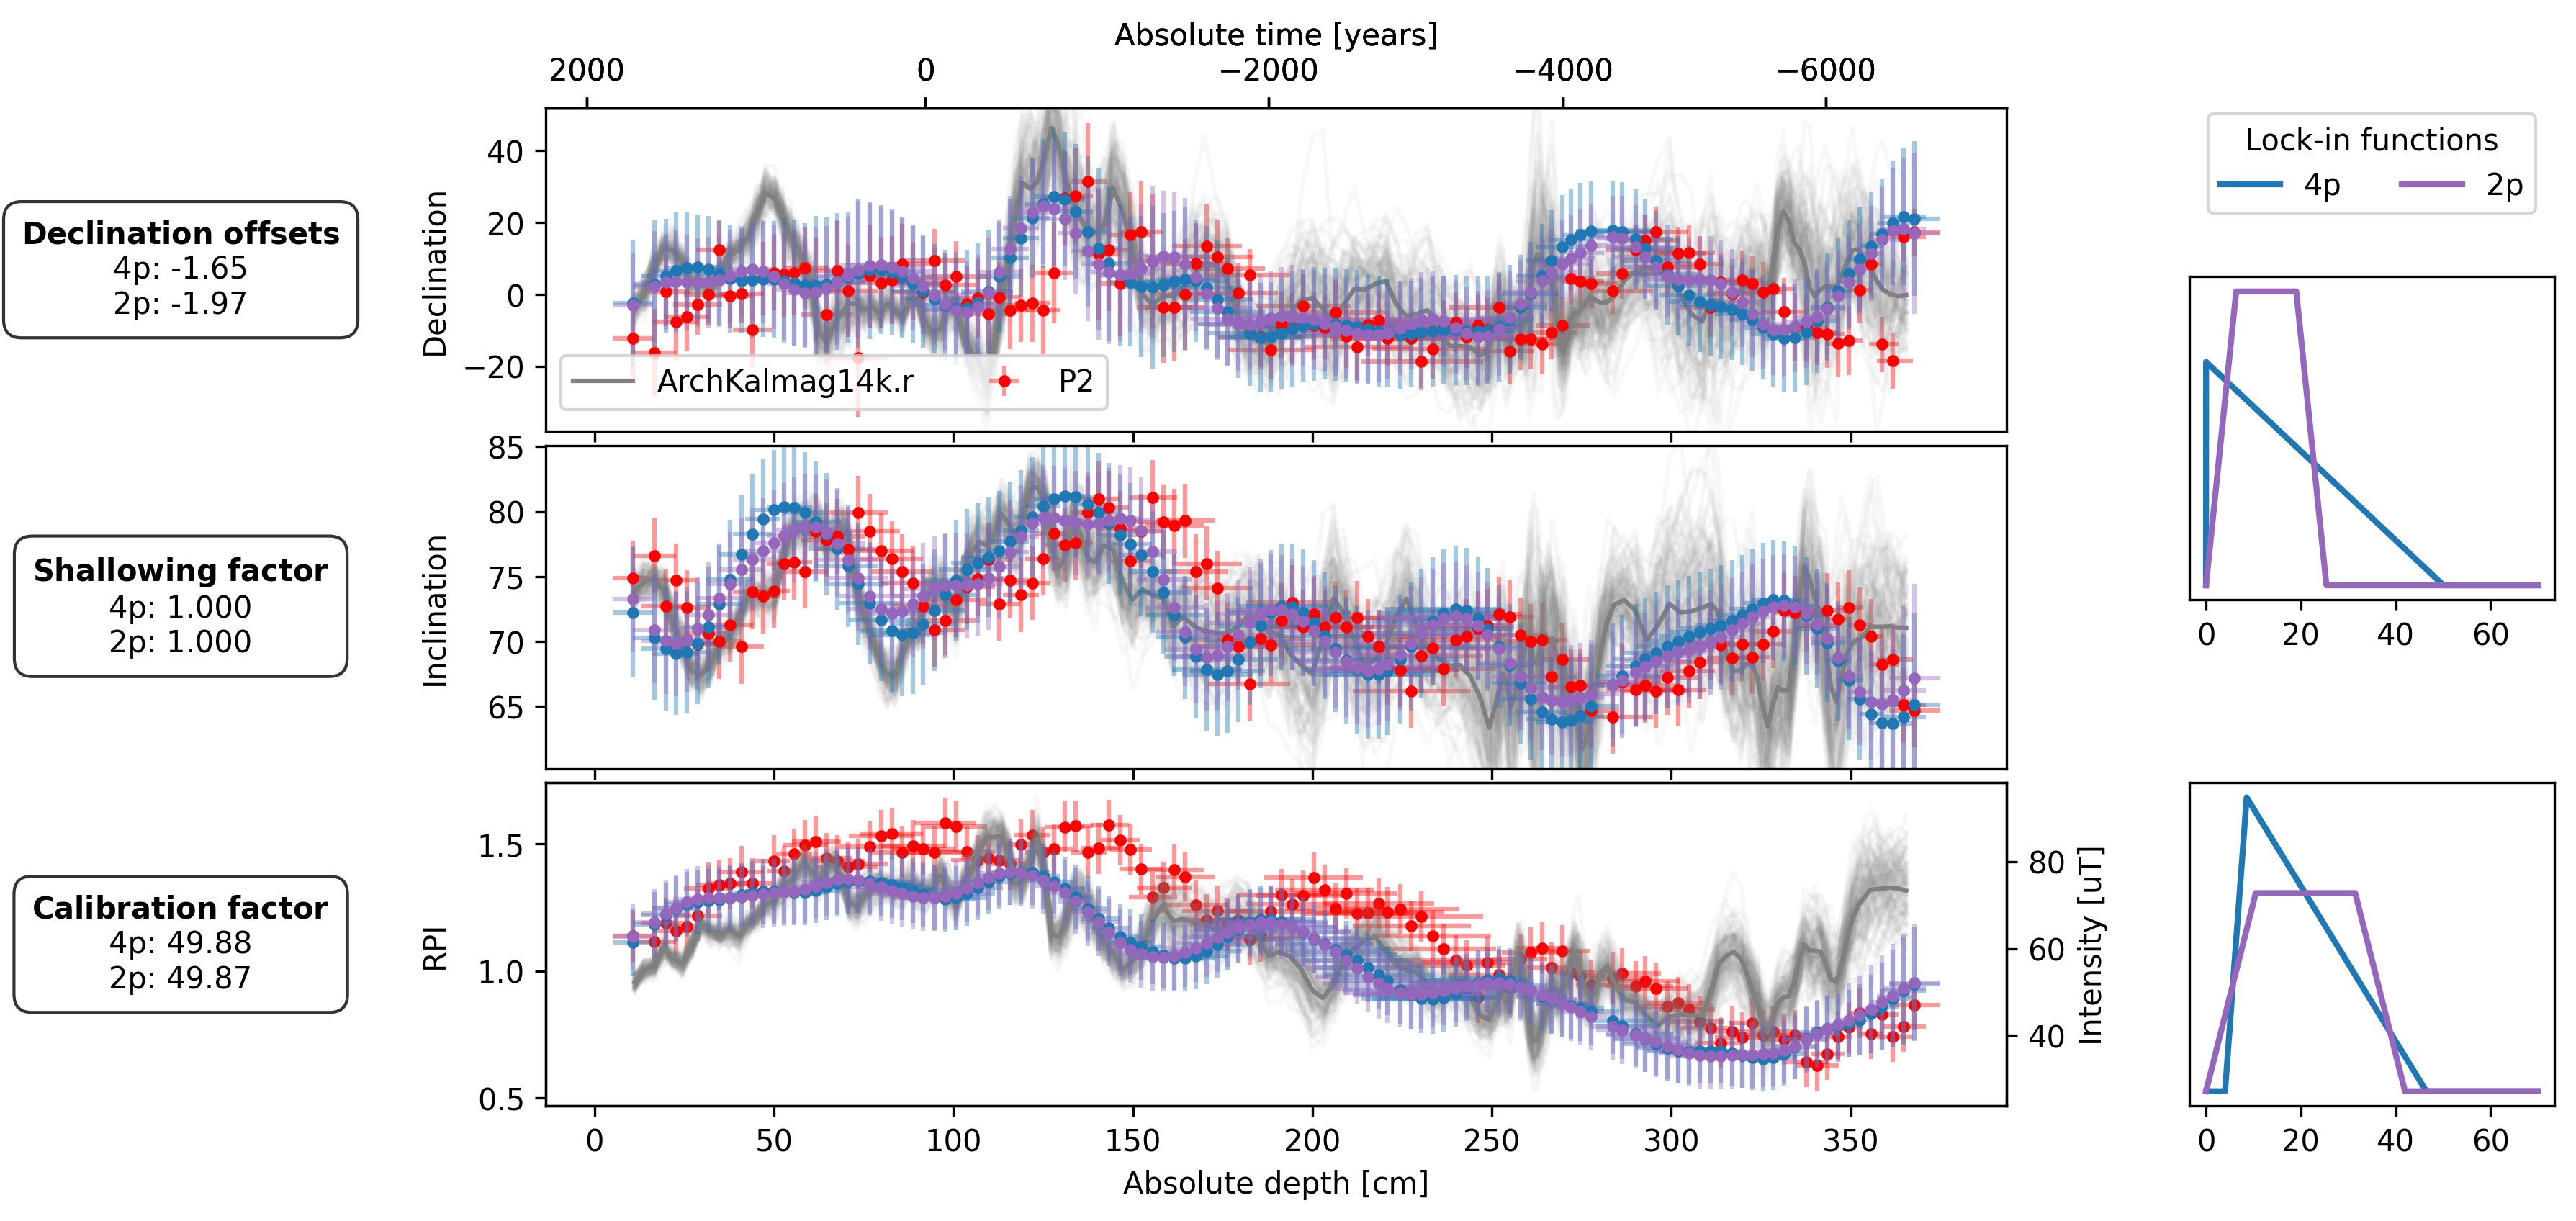

In [9]:
import matplotlib.pyplot as plt
from sedprep.utils import lif
from sedprep.plot_functions import plot_DIF
r = requests.get("https://nextcloud.gfz-potsdam.de/s/drmP3eSSg8Pq4r4/download", stream=True)
akm_file = np.load(io.BytesIO(r.raw.read()), allow_pickle=True)
# akm_file = np.load("dat/akm14k.r_samples.npz")

lif_knots = np.linspace(0, 70, 5000)
props = dict(boxstyle='round,pad=0.6', facecolor='none', alpha=0.8)

fig, axs = plt.subplot_mosaic(
    2 * [3 * ["D"] + ["."]]
    + 2 * [3 * ["D"] + ["LIF_DI"]]
    + 2 * [3 * ["I"] + ["LIF_DI"]]
    + 2 * [3 * ["I"] + ["."]]
    + 4 * [3 * ["F"] + ["LIF_F"]], figsize=(12, 6), dpi=300)
fig.align_ylabels()
plt.subplots_adjust(wspace=0.5, hspace=0.2) 
axF_twin = axs["F"].twinx()
[ax.set_xticklabels([]) for ax in [axs["D"], axs["I"]]]
plot_DIF(sed, axs["D"], axs["I"], axs["F"], axF_twin, time_or_depth="depth", xerr=True, yerr=True, legend=False, model_file=akm_file)
axs["D"].legend(bbox_to_anchor=(0, 0.02), loc="lower left", ncol=3)
plot_DIF(prep_df_4p, axs["D"], axs["I"], axF_twin, time_or_depth="depth", xerr=True, yerr=True, legend=False, distinguish_subs=False)
plot_DIF(prep_df_2p, axs["D"], axs["I"], axF_twin, time_or_depth="depth", xerr=True, yerr=True, legend=False, distinguish_subs=False, color="C4")
axF_twin.set_ylabel("Intensity [uT]")
for ax, bs_4p, bs_2p in zip([axs["LIF_DI"], axs["LIF_F"]], [est_bs_DI_4p, est_bs_F_4p], [est_bs_DI_2p, est_bs_F_2p]):
    ax.plot(lif_knots, lif(bs_4p)(lif_knots), c="C0", lw=2, zorder=3, label="4p")
    ax.plot(lif_knots, lif(bs_2p)(lif_knots), c="C4", lw=2, zorder=3, label="2p")
    ax.set_yticks([], [])
axs["LIF_DI"].legend(bbox_to_anchor=(0.5, 1.35), title="Lock-in functions", loc="center", ncol=3)
offsets_text = r"$\bf{Declination\ offsets}$" + "\n"
offsets_text += f"4p: {est_offsets_4p[0]:.2f}\n"
offsets_text += f"2p: {est_offsets_2p[0]:.2f}"
f_shallow_text = r"$\bf{Shallowing\ factor}$" + "\n"
f_shallow_text += f"4p: {est_f_shallow_4p:.3f}\n"
f_shallow_text += f"2p: {est_f_shallow_2p:.3f}"
cal_fac_text = r"$\bf{Calibration\ factor}$" + "\n"
cal_fac_text += f"4p: {est_cal_fac_4p:.2f}\n"
cal_fac_text += f"2p: {est_cal_fac_2p:.2f}"
axs["D"].text(-0.25, 0.5, offsets_text, transform=axs["D"].transAxes, va="center", ha="center", bbox=props)
axs["I"].text(-0.25, 0.5, f_shallow_text, transform=axs["I"].transAxes, va="center", ha="center", bbox=props)
axs["F"].text(-0.25, 0.5, cal_fac_text, transform=axs["F"].transAxes, va="center", ha="center", bbox=props)
# fig.suptitle(f"Results for {name}", x=0, fontweight="bold")
plt.show()

Finally, we also present the results for a second Examples called BIR. For details see [Bohsung](link)

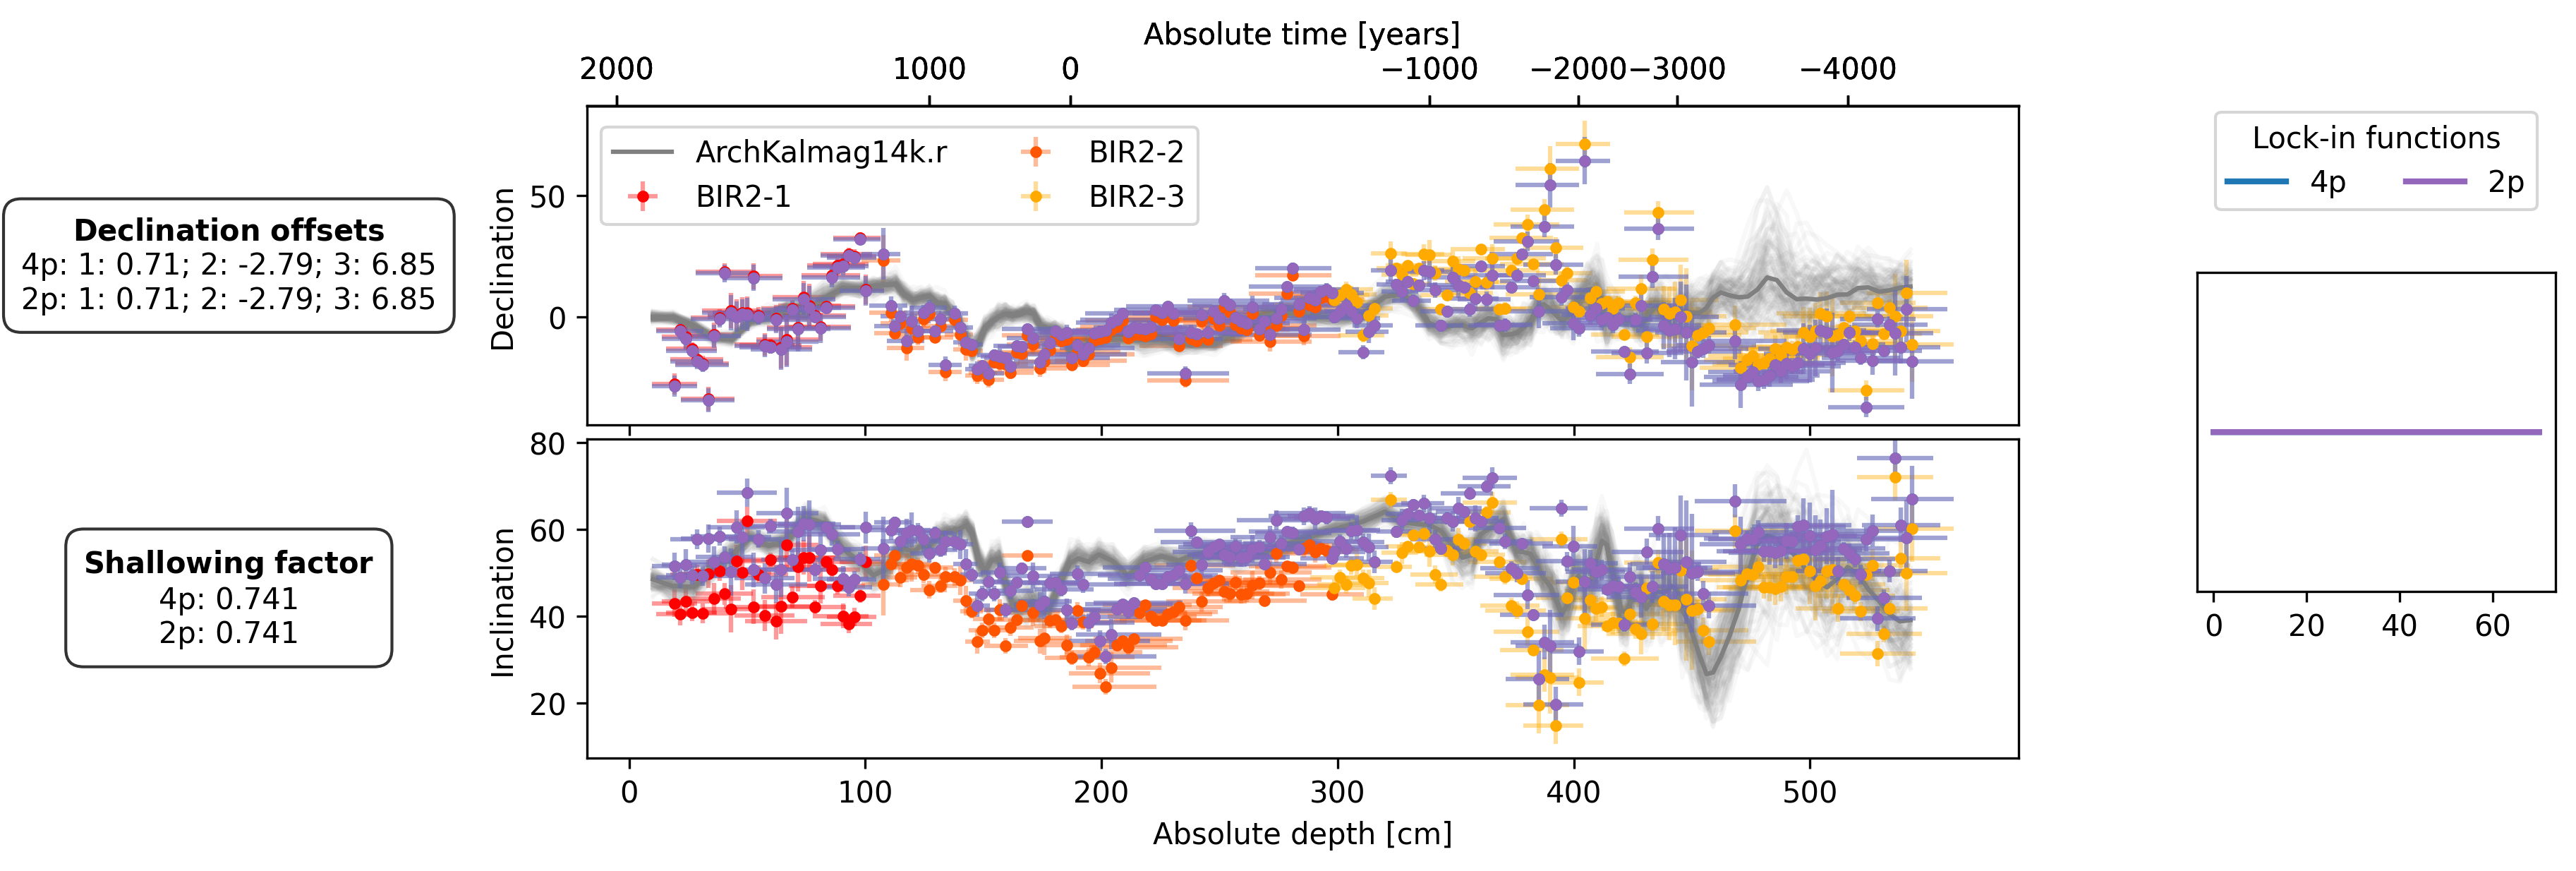

In [14]:
sed = pd.read_csv(f"dat/BIR_prepared.csv")

res = pd.read_csv(f"results/estimated_parameters/BIR.csv")
res = res[res.optimizer == "scipy"].reset_index(drop=True)
est_bs_DI_4p = ast.literal_eval(res[~res.bs_DI.isna()].bs_DI.values[0])
est_bs_F_4p = ast.literal_eval(res[~res.bs_F.isna()].bs_F.values[0])
est_offsets_4p = json.loads(res[~res.offsets.isna()].offsets.values[0].replace("'", '"'))
est_f_shallow_4p = res[~res.f_shallow.isna()].f_shallow.values[0]
est_cal_fac_4p = res[~res.cal_fac.isna()].cal_fac.values[0]
est_bs_DI_2p = ast.literal_eval(res[~res.bs_DI.isna()].bs_DI.values[1])
est_bs_F_2p = ast.literal_eval(res[~res.bs_F.isna()].bs_F.values[1])
est_offsets_2p = json.loads(res[~res.offsets.isna()].offsets.values[1].replace("'", '"'))
est_f_shallow_2p = res[~res.f_shallow.isna()].f_shallow.values[1]
est_cal_fac_2p = res[~res.cal_fac.isna()].cal_fac.values[1]

prep_df_4p = pd.read_csv(f"results/preprocessed_data/BIR_preprocessed_4p.csv")
prep_df_2p = pd.read_csv(f"results/preprocessed_data/BIR_preprocessed_2p.csv")

fig, axs = plt.subplot_mosaic(
    2 * [3 * ["D"] + ["."]]
    + 2 * [3 * ["D"] + ["LIF_DI"]]
    + 2 * [3 * ["I"] + ["LIF_DI"]]
    + 2 * [3 * ["I"] + ["."]], figsize=(12, 4), dpi=300)
fig.align_ylabels()
plt.subplots_adjust(wspace=0.5, hspace=0.2) 
axs["D"].set_xticklabels([])
plot_DIF(sed, axs["D"], axs["I"], time_or_depth="depth", xerr=True, yerr=True, legend=False, model_file=akm_file)
axs["D"].legend(bbox_to_anchor=(0, 0.98), loc="upper left", ncol=2)
plot_DIF(prep_df_4p, axs["D"], axs["I"], time_or_depth="depth", xerr=True, yerr=True, legend=False, distinguish_subs=False)
plot_DIF(prep_df_2p, axs["D"], axs["I"], time_or_depth="depth", xerr=True, yerr=True, legend=False, distinguish_subs=False, color="C4")
axs["LIF_DI"].plot(lif_knots, lif(est_bs_DI_4p)(lif_knots), c="C0", lw=2, zorder=3, label="4p")
axs["LIF_DI"].plot(lif_knots, lif(est_bs_DI_2p)(lif_knots), c="C4", lw=2, zorder=3, label="2p")
axs["LIF_DI"].set_yticks([], [])
axs["LIF_DI"].legend(bbox_to_anchor=(0.5, 1.35), title="Lock-in functions", loc="center", ncol=3)
offsets_text = r"$\bf{Declination\ offsets}$" + "\n"
offsets_text += f"4p: 1: {est_offsets_4p['BIR2-1']:.2f}; 2: {est_offsets_4p['BIR2-2']:.2f}; 3: {est_offsets_4p['BIR2-3']:.2f}\n"
offsets_text += f"2p: 1: {est_offsets_2p['BIR2-1']:.2f}; 2: {est_offsets_2p['BIR2-2']:.2f}; 3: {est_offsets_2p['BIR2-3']:.2f}"
f_shallow_text = r"$\bf{Shallowing\ factor}$" + "\n"
f_shallow_text += f"4p: {est_f_shallow_4p:.3f}\n"
f_shallow_text += f"2p: {est_f_shallow_2p:.3f}"
axs["D"].text(-0.25, 0.5, offsets_text, transform=axs["D"].transAxes, va="center", ha="center", bbox=props)
axs["I"].text(-0.25, 0.5, f_shallow_text, transform=axs["I"].transAxes, va="center", ha="center", bbox=props)
# fig.suptitle(f"Results for {name}", x=0, fontweight="bold")
plt.show()

The file that was used to get the results presented here can be found in "src/optimize.py".

The link to download the age-depth model of BIR is "https://nextcloud.gfz-potsdam.de/s/naGec8zgSmNbE2P/download".